# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [32]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
mouseline = 'pv'  # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
rel_std_bounds = None  # critical relative variation factor determining valid range boundaries
xkeys_plt = [  # Input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # Plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False
plot_traces = False

### Derived parameters

In [33]:
# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'

isnotpv = mouseline != 'pv'

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 06/03/2023 17:13:42: assembling batch analysis settings...
 06/03/2023 17:13:42: pv main analysis notebook started on 2023-03-06 at 17:13:42


### Input summary table figure

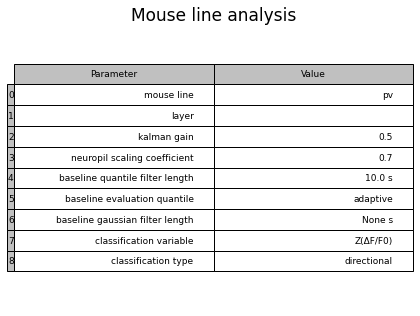

In [34]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional"
    }, title='Mouse line analysis', aspect=1.5)

### Load data

In [35]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats)

 06/03/2023 17:13:43: loading data from /Users/tlemaire/Documents/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv:
 06/03/2023 17:13:43: loading mouse-region data from 20190606_mouse2_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190606_mouse2_region2.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190629_mouse2_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190630_mouse3_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190702_mouse1_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190702_mouse5_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190703_mouse4_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190821_mouse3_region1.h5
 06/03/2023 17:13:43: loading mouse-region data from 20190821_mouse6_region1.h5
 06/03/2023 17:13:44: loading mouse-region d

run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190606_mouse2_region1,109,nan,nan,110,110,110,110,109,109,109,108,109,nan,nan,nan
20190606_mouse2_region2,122,nan,nan,122,122,122,122,122,122,122,122,122,nan,nan,nan
20190629_mouse2_region1,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77
20190630_mouse3_region1,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53
20190702_mouse1_region1,169,169,169,169,169,169,169,169,169,169,169,165,169,169,169
20190702_mouse5_region1,102,102,102,102,102,102,101,102,100,102,102,102,102,102,102
20190703_mouse4_region1,82,82,82,82,82,82,82,82,82,81,82,82,82,81,82


### Load exclusion table

In [36]:
exclude_table = get_exclude_table(line=mouseline)
exclude_table

,poor segmentation,potential dead cells,large variation in fluorescence baseline,no/weak response,abnormal response amplitudes,abnormal drop 50-60% DC,abnormal drop 0.4-0.6 MPa
dataset,,,,,,,
20190606_mouse2_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190606_mouse2_region2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190629_mouse2_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190630_mouse3_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190702_mouse1_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190702_mouse5_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190703_mouse4_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190821_mouse3_region1,NaN,NaN,y,NaN,NaN,NaN,NaN
20190821_mouse6_region1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Inspect cell maps and exclude outlier datasets 

 06/03/2023 17:13:48: plotting cell maps...


100%|██████████| 10/10 [00:00<00:00, 15.94it/s]

 06/03/2023 17:13:49: empty exclude list -> ignoring


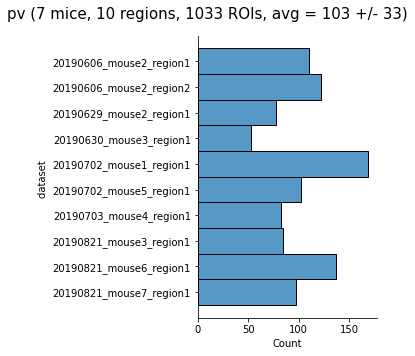

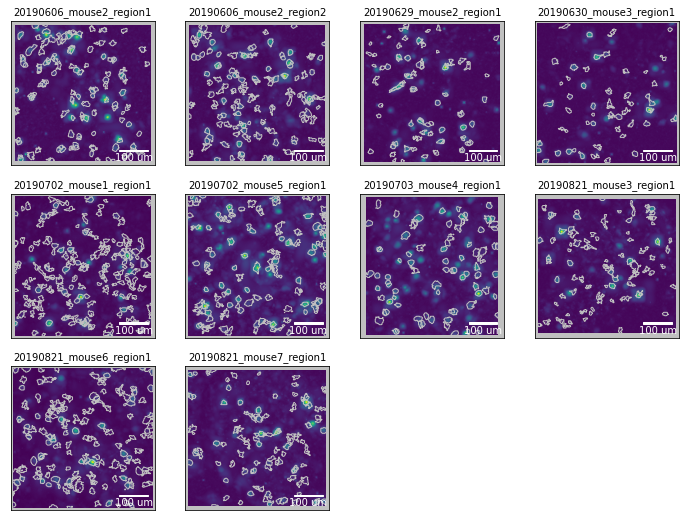

In [37]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)
seg_exclude = get_exclude_list(exclude_table, [Label.POORSEG, Label.DEADCELLS])
figs['cellmaps'] = plot_cell_maps(
    ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour', hue=None, 
    outliers=seg_exclude
)
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=seg_exclude)

### Inspect baseline variation throughout experiments and exclude outliers

 06/03/2023 17:13:49: inspecting variations in baseline fluorescence across experiments...
 06/03/2023 17:13:49: identified 1 datasets with baseline fluorescence variations outside (0.75, 1.25):
  - 20190821_mouse3_region1
 06/03/2023 17:13:49: excluding the following datasets from analysis:
 - 20190821_mouse3_region1


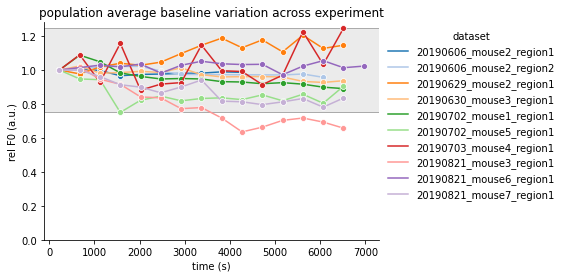

In [38]:
relF0_key = f'rel {Label.F0}'
from constants import MAX_F0_REL_VAR

def get_rel_F0(data, aggbyrun=True):
    ''' Extract temporal evolution of F0 '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    runid_map = trialagg_stats.loc[dataset_id, Label.RUNID].groupby(Label.RUN).first()
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    data[Label.TIME] = get_index_along_experiment(data.index, runid_map=runid_map) / fps
    # If specified, aggregate by run
    data = data.groupby(Label.RUN).median()
    # Compute relative variation
    i0 = data[Label.TIME].idxmin()
    y0 = data.loc[i0, Label.F0]
    data[relF0_key] = data[Label.F0] / y0
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Plot time evolution of average baseline along experiment, for each dataset
logger.info('inspecting variations in baseline fluorescence across experiments...')
figs['popavg F0 across experiment'], ax = plt.subplots(figsize=(6, 4))
sns.despine(ax=ax)
ax.set_title(f'population average baseline variation across experiment')
popagg_F0_per_run = popagg_timeseries.groupby(Label.DATASET).apply(get_rel_F0)
rel_F0_bounds = (1 - MAX_F0_REL_VAR, 1 + MAX_F0_REL_VAR)
sns.lineplot(
    data=popagg_F0_per_run,
    x=Label.TIME, 
    y=relF0_key, 
    ci=None, 
    ax=ax, 
    hue=Label.DATASET,
    marker='o',
    palette='tab20',
)
ax.axhspan(*rel_F0_bounds, fc='silver', ec='k', alpha=0.3)
ax.set_ylim(0, ax.get_ylim()[1])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)

# Identify datasets with outlier variations in baseline fluorescence
relF0_outlier_runs = ~is_within(popagg_F0_per_run[relF0_key], rel_F0_bounds)
noutlier_runs = relF0_outlier_runs.groupby(Label.DATASET).sum()
relF0_outliers = noutlier_runs[noutlier_runs > 0].index.values.tolist()
noutliers = len(relF0_outliers)
if noutliers > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {noutliers} datasets with baseline fluorescence variations outside {rel_F0_bounds}:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=relF0_outliers)

### Inspect parameter dependency curves and exclude outlier datasets

 06/03/2023 17:13:50: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 06/03/2023 17:13:50: plotting ΔF/F0 stimulation parameters dependencies...
 06/03/2023 17:13:50: sub-indexing data...
 06/03/2023 17:13:50: filtering data...
 06/03/2023 17:13:50: cross-checking filters...
 06/03/2023 17:13:50: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 06/03/2023 17:13:50: sub-indexing data...
 06/03/2023 17:13:50: filtering data...
 06/03/2023 17:13:50: cross-checking filters...
 06/03/2023 17:13:50: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 06/03/2023 17:13:50: plotting evoked ΔF/F0 change ISPTA dependency across responders...
 06/03/2023 17:13:50: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 06/03/2023 17:13:50: sub-indexing data...
 06/03/2023 17:13:50: filtering data...
 06/03/2023 17:13:50: cross-checking filters...
 06/03/2023 17:13:50: grouping by dataset, averaging and plotti

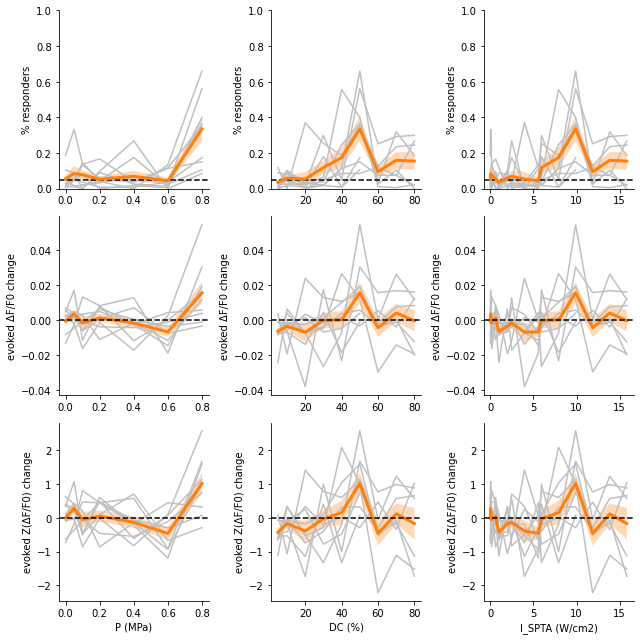

In [39]:
ykey_diff = get_change_key(Label.DFF)
for criterion in [Label.STRONGRESP, Label.NORESP, Label.DROP5060DC, Label.DROP0406MPA]:
    exclude_list = get_exclude_list(exclude_table, criterion)
    if len(exclude_list) > 0:
        figs[f'stimparamdeps exclude {criterion}'] = plot_stimparams_dependency(
            trialagg_stats.copy(),
            xkeys=xkeys_plt,
            ykey=ykey_diff, 
            hue=Label.DATASET,
            avgprop='whue', 
            ci=None,
            outliers=exclude_list
        )
        for ax in figs[f'stimparamdeps exclude {criterion}'].axes:
            ax.set_title(None)
        figs[f'stimparamdeps exclude {criterion}'].suptitle(f'{criterion} exclusion')
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = exclude_datasets(
            trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, to_exclude=exclude_list)

# Visualize dependency curves post exclusions
figs['stimparamdeps post-exclude'] = plot_all_deps(
    trialagg_stats,
    [Label.P, Label.DC, Label.ISPTA],
    ykeys_plt, 
    palette='uniform',
    avg_color='line',
)

### Inspect dynamics of population-averaged activity

 06/03/2023 17:13:51: defining order 2 bandstop BW filter with fc = 0.090 Hz - 0.500 Hz
 06/03/2023 17:13:51: computing frequency spectra across run...
 06/03/2023 17:13:51: restricting output to frequencies below 0.50 Hz
 06/03/2023 17:13:51: adding reference lines at trial-repetition frequency (0.04 Hz)
 06/03/2023 17:13:51: marking 0.09 Hz - 0.50 Hz frequency band
 06/03/2023 17:13:51: computing frequency spectra across run...
 06/03/2023 17:13:51: restricting output to frequencies below 0.50 Hz
 06/03/2023 17:13:51: adding reference lines at trial-repetition frequency (0.04 Hz)
 06/03/2023 17:13:51: marking 0.09 Hz - 0.50 Hz frequency band
 06/03/2023 17:13:51: computing frequency spectra across run...
 06/03/2023 17:13:51: restricting output to frequencies below 0.50 Hz
 06/03/2023 17:13:52: adding reference lines at trial-repetition frequency (0.04 Hz)
 06/03/2023 17:13:52: marking 0.09 Hz - 0.50 Hz frequency band
 06/03/2023 17:13:52: computing frequency spectra across run...
 0

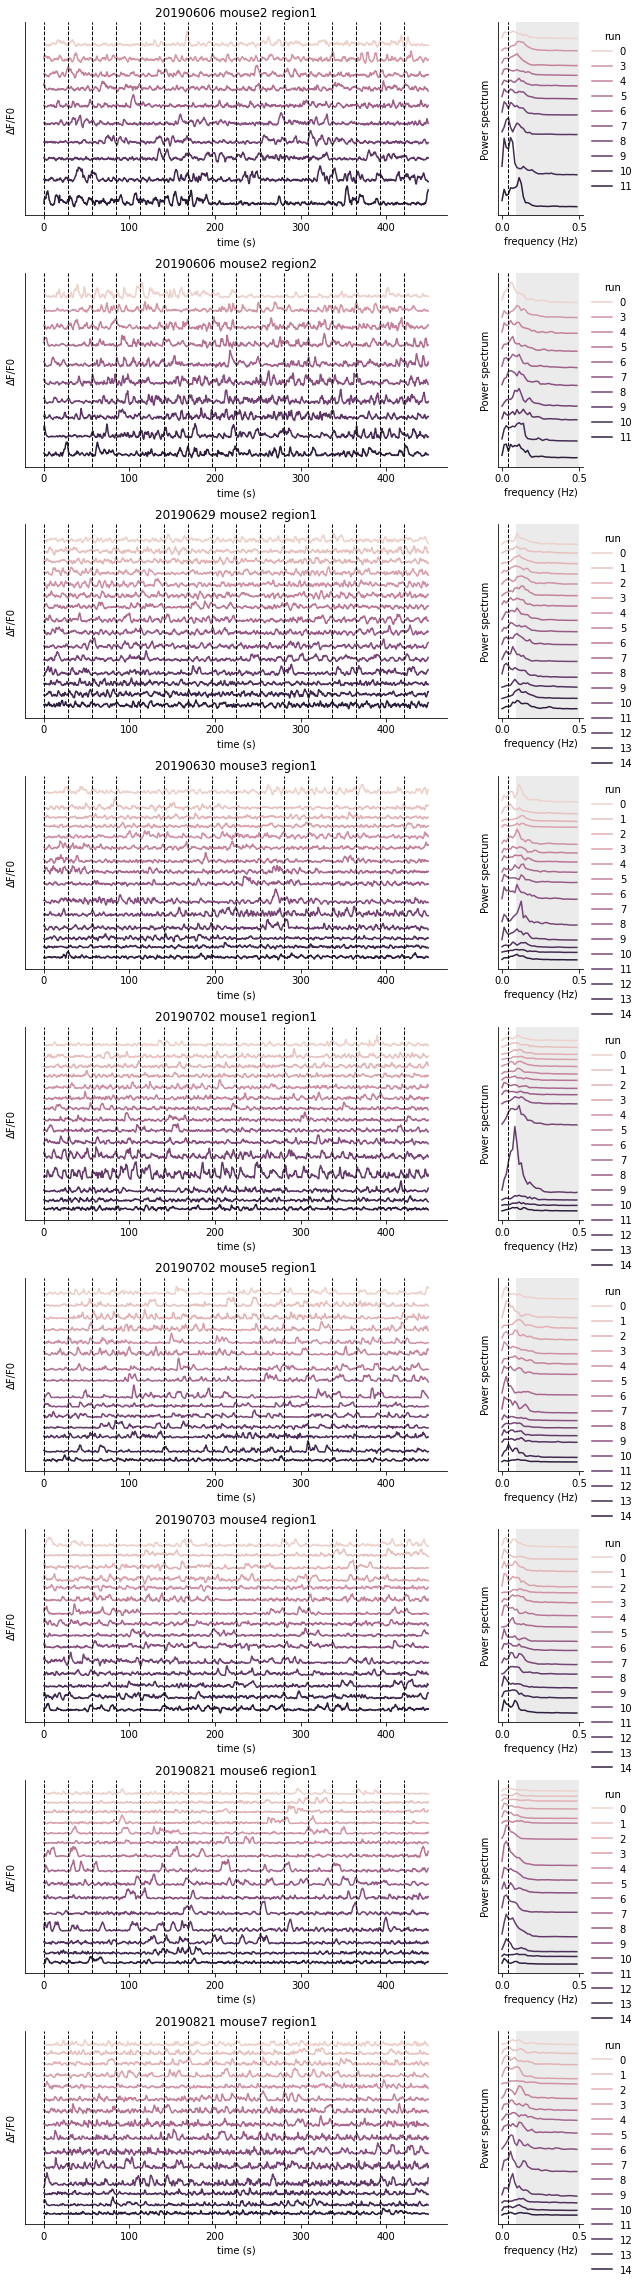

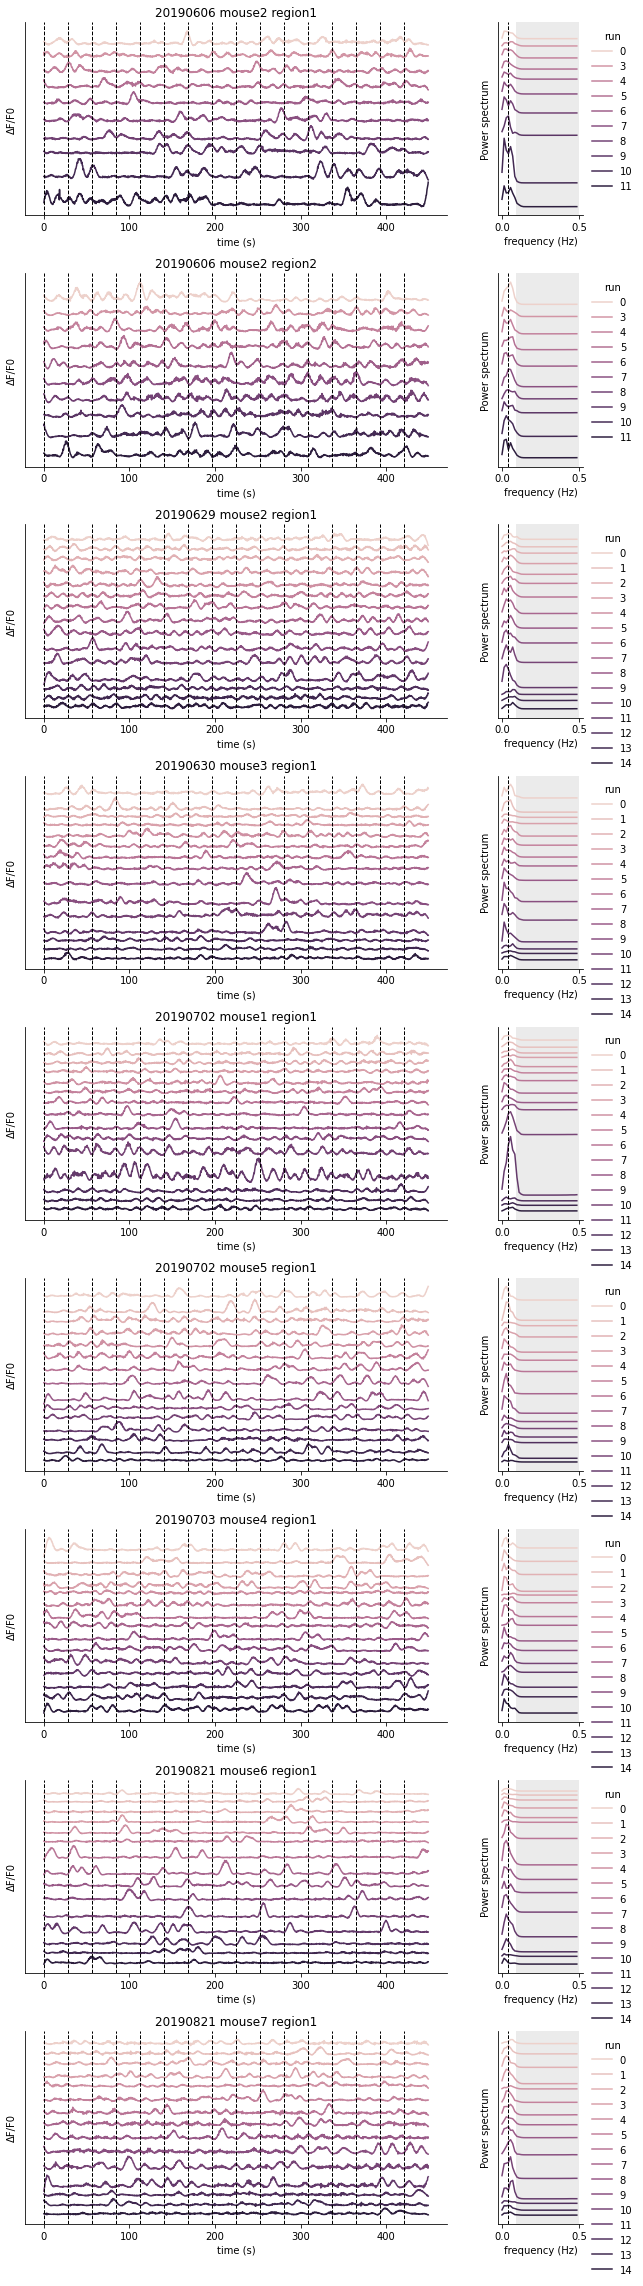

In [40]:
%%skip $isnotpv

# Define output metrics
ykey = Label.DFF

# Define frequency band for neural oscillations of interest
fband_osc = [.09, .5]  # Hz

# Extract frame rate
fps = get_singleton(trialagg_stats, Label.FPS)

# Define plotting options
merge_metrics = True
fmax = .5  # upper frequency limit for specturm graphs

# Define BW filter function and apply it to population-averaged data, per dataset and run
filterfunc = get_butter_filter_func(fps, fband_osc, btype='bandstop')
popagg_timeseries_filtered = (popagg_timeseries[ykey]
    .groupby([Label.DATASET, Label.RUN])
    .apply(filterfunc)
    .to_frame()
)

# Plot timecourses and frequency spectra across runs, for original and filtered data
tmpdata = {
    'original': popagg_timeseries,
    'filtered': popagg_timeseries_filtered
}
for k, v in tmpdata.items():
    if merge_metrics:
        groups = v.groupby(Label.DATASET)
        figs[f'popagg {ykey} metrics {k}'], axes = plt.subplots(
            groups.ngroups, 2, figsize=(10, 4.5 * groups.ngroups), 
            gridspec_kw=dict(width_ratios=(1, .2)))
        for axrow, (dadaset_id, gdata) in zip(axes, groups):
            mydata = gdata.reset_index(level=Label.DATASET, drop=True)
            plot_popagg_timecourse(mydata, ykey, fps, ax=axrow[0], legend=False)
            plot_popagg_frequency_spectrum(mydata, ykey, fps, fmax=fmax, fband=fband_osc, ax=axrow[1])
            sns.move_legend(axrow[1], 'upper left', bbox_to_anchor=(1, 1), frameon=False)
            axrow[0].set_title(dadaset_id.replace('_', ' '))
        figs[f'popagg {ykey} metrics {k}'].subplots_adjust(hspace=0.3)
    else:
        figs[f'popagg {ykey} profiles {k}'] = plot_popagg_timecourse(
            v, ykey, fps, normalize_gby=Label.DATASET, title=mouseline)
        figs[f'popagg {ykey} frequency spectra {k}'] = plot_popagg_frequency_spectrum(
            v, ykey, fps, fmax=fmax, fband=fband_osc, 
            normalize_gby=Label.DATASET, title=mouseline)

### Inspect run presentation order per dataset and potential consequences on evoked activity

 06/03/2023 17:14:03: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 06/03/2023 17:14:03: run ID not part of (P (MPa), DC (%)) -> no filtering
 06/03/2023 17:14:03: sub-indexing data...
 06/03/2023 17:14:03: filtering data...
 06/03/2023 17:14:03: cross-checking filters...
 06/03/2023 17:14:03: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 06/03/2023 17:14:04: plotting evoked ΔF/F0 change run sequence dependency across dataset...
 06/03/2023 17:14:04: run ID not part of (P (MPa), DC (%)) -> no filtering
 06/03/2023 17:14:04: sub-indexing data...
 06/03/2023 17:14:04: filtering data...
 06/03/2023 17:14:04: cross-checking filters...
 06/03/2023 17:14:04: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. run ID ...
 06/03/2023 17:14:04: parameter sequences across datasets:


dataset,20190606_mouse2_region1,20190606_mouse2_region2,20190629_mouse2_region1,20190630_mouse3_region1,20190702_mouse1_region1,20190702_mouse5_region1,20190703_mouse4_region1,20190821_mouse6_region1,20190821_mouse7_region1
run ID,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_40%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_30%DC,NaN,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_20%DC,0.80MPa_40%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_10%DC,0.80MPa_30%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_05%DC,0.80MPa_20%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.00MPa_50%DC,0.80MPa_10%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,NaN,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.40MPa_50%DC,0.80MPa_60%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,NaN,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.20MPa_50%DC,0.80MPa_70%DC,0.20MPa_50%DC


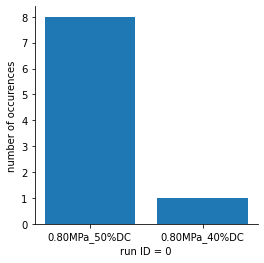

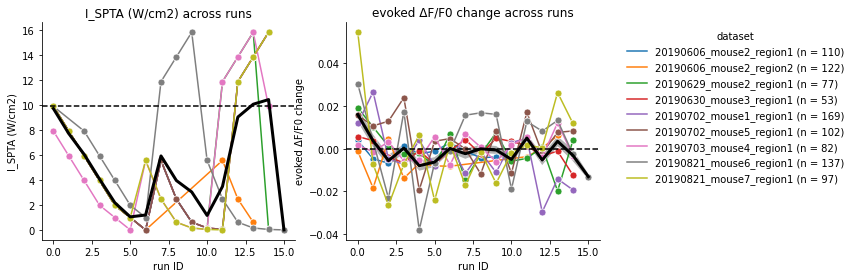

In [41]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Construct palette based on first presented parameters
first_params = param_seqs.loc[0, :]
first_params_mapper = dict(zip(
    first_params.unique(), 
    [f'C{i}' for i in range(first_params.nunique())]
))
first_param_palette = first_params.map(first_params_mapper).to_dict()

# Plot distribution of first persented stimulus
figs['first stimulus distribution'] = plot_occurence_counts(param_seqs, runid=0)

# Plot Ispta and evoked DFF across run sequences, per dataset
ykey_diff = get_change_key(Label.DFF)
ykeys_seq = [Label.ISPTA, ykey_diff]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(
    1, len(ykeys_seq), figsize=(5 * len(ykeys_seq), 4))
axes = np.atleast_1d(axes)
for i, (ykey, ax) in enumerate(zip(ykeys_seq, axes)):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, xkey=Label.RUNID, ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, avgprop='whue', errprop='intra', ax=ax,
        legend=i == len(ykeys_seq) - 1, title=f'{ykey} across runs',
        ci=None, marker='o')

logger.info('parameter sequences across datasets:')
param_seqs

### Fit response strength to ISPTA and project fit across run sequences to compare with data 

 06/03/2023 17:14:13: computing ROI-weighted average of (9 datasets x 347 ROIs x 15 runs) "evoked ΔF/F0 change" series across run...
 06/03/2023 17:14:13: performing linear fit between (evoked ΔF/F0 change)^2 and I_SPTA (W/cm2)...
 06/03/2023 17:14:14: computing ROI-weighted average of (9 datasets x 347 ROIs x 15 runs) "evoked ΔF/F0 change" series across run ID...
 06/03/2023 17:14:14: computing ROI-weighted average of (9 datasets x 347 ROIs x 15 runs) "I_SPTA (W/cm2)" series across run ID...


/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


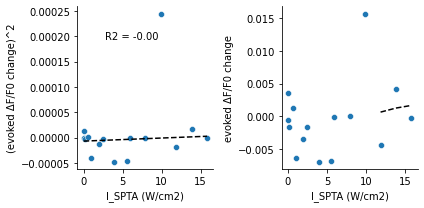

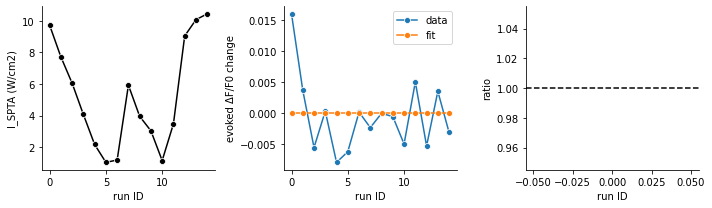

In [42]:
# Compute weighted average of output metrics across datasets
lineavg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUN, ykey=ykey_diff).rename(columns={'mean': ykey_diff})
# Sort by increasing ISPTA
lineavg_stats = lineavg_stats.sort_values(Label.ISPTA)

# Perform linear fit between ISPTA and square of response stength
squared_ykey_diff = f'({ykey_diff})^2'
logger.info(f'performing linear fit between {squared_ykey_diff} and {Label.ISPTA}...')
lineavg_stats[squared_ykey_diff] = lineavg_stats[ykey_diff]**2 * np.sign(lineavg_stats[ykey_diff])
b, m = robust_linreg(lineavg_stats[squared_ykey_diff], x=lineavg_stats[Label.ISPTA])
r2 = rsquared(lineavg_stats[squared_ykey_diff], m * lineavg_stats[Label.ISPTA] + b)

# Plot data and fitted profile
figs['isptafit'], axes = plt.subplots(1, 2, figsize=(6, 3))
for ax in axes:
    sns.despine(ax=ax)
sns.scatterplot(
    data=lineavg_stats, x=Label.ISPTA, y=squared_ykey_diff, ax=axes[0], ci=None, marker='o')
axes[0].plot(lineavg_stats[Label.ISPTA], m * lineavg_stats[Label.ISPTA] + b, '--k')
axes[0].text(0.2, 0.8, f'R2 = {r2:.2f}', transform=axes[0].transAxes)
sns.scatterplot(
    data=lineavg_stats, x=Label.ISPTA, y=ykey_diff, ax=axes[1], ci=None, marker='o')
axes[1].plot(lineavg_stats[Label.ISPTA], np.sqrt(m * lineavg_stats[Label.ISPTA] + b), '--k')
figs['isptafit'].tight_layout()

# Compute average ISPTA and response strength per run ID
runidavg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUNID, ykey=ykey_diff).rename(columns={'mean': ykey_diff})
runidavg_stats[Label.ISPTA] = get_crossdataset_average(
    trialagg_stats, Label.RUNID, ykey=Label.ISPTA)['mean']
# Restrict to first 15 runs to eliminate sparse run 16
runidavg_stats = runidavg_stats.iloc[:-1, :]

# Predict response strength over time bases on ISPTA fit
runidavg_stats['fit'] = np.sqrt(m * runidavg_stats[Label.ISPTA] + b).fillna(0.)

# Compute ratio of fit vs data to visualize potential drift ...
runidavg_stats['ratio'] = runidavg_stats[ykey_diff] / runidavg_stats['fit']

# Plot evolution of ISPTA and response strength (data & fit) over runs
figs['resp vs time - data vs. pred'], axes = plt.subplots(1, 3, figsize=(10, 3))
for ax in axes:
    sns.despine(ax=ax)
sns.lineplot(
    data=runidavg_stats, x=Label.RUNID, y=Label.ISPTA, ax=axes[0], marker='o', color='k')
sns.lineplot(data=runidavg_stats, x=Label.RUNID, y=ykey_diff, ax=axes[1], marker='o', label='data')
sns.lineplot(data=runidavg_stats, x=Label.RUNID, y='fit', ax=axes[1], marker='o', label='fit')
axes[1].legend()
sns.lineplot(
    data=runidavg_stats, x=Label.RUNID, y='ratio', ax=axes[2], marker='o', color='k')
axes[2].axhline(1., c='k', ls='--')
figs['resp vs time - data vs. pred'].tight_layout()

### Inspect response stationarity throughout trial sequences

 06/03/2023 17:14:17: computing population average evoked ΔF/F0 change for each trial...
 06/03/2023 17:14:17: plotting evoked ΔF/F0 change along trial sequences...
 06/03/2023 17:14:18: computing ROI-weighted average of (9 datasets x 347 ROIs x 15 runs x 16 trials) "evoked ΔF/F0 change" series across run ID & trial...


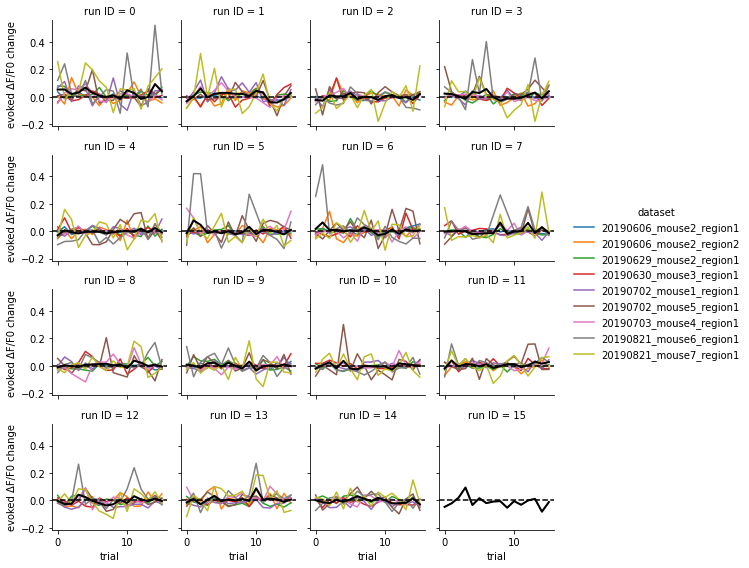

In [43]:
# Determine output metrics
ykey_diff = get_change_key(Label.DFF)
stationarity_gby = Label.RUNID

# Compute population-average stats for each trial 
logger.info(f'computing population average {ykey_diff} for each trial...')
input_keys = [Label.P, Label.DC, Label.ISPTA, Label.RUNID, ykey_diff]
popagg_stats = (ext_stats[input_keys]   # select columns of interest
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])  # group by dataset, run & trial
    .mean()   # average across ROIs
    .astype({Label.RUNID: int})  # cast run ID to integer
    .query(f'`{Label.DC}` > 1')  # restrict to DC > 1 %
    .round(decimals={Label.P: 2, Label.DC: 2, Label.ISPTA: 2})  # round input params to 2 decimals
)

# Plot evolution of response strength along trial sequence, by run ID
logger.info(f'plotting {ykey_diff} along trial sequences...')
trialseq_fgkwargs = dict(
    x=Label.TRIAL,
    y=ykey_diff,
    col=stationarity_gby,
    col_wrap=4,
    height=2.,
    legend='full'
)
fg = sns.relplot(
    kind='line',
    data=popagg_stats, 
    hue=Label.DATASET,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')
# Add weighted-average profiles on top
weighted_popagg_stats = get_crossdataset_average(
    ext_stats, [stationarity_gby, Label.TRIAL], ykey_diff)
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata['mean'], c='k', lw=2)
figs[f'{ykey_diff} along trial seq'] = fg.figure

### Check for response stationarity throughout trial sequence

 06/03/2023 17:14:22: plotting evoked ΔF/F0 change along trial sequences...
 06/03/2023 17:14:26: adding regression estimates...
 06/03/2023 17:14:34: assessing evoked ΔF/F0 change stationarity, by run ID, with linear regression analysis
 06/03/2023 17:14:34: no significant evoked ΔF/F0 change non-stationarity identified


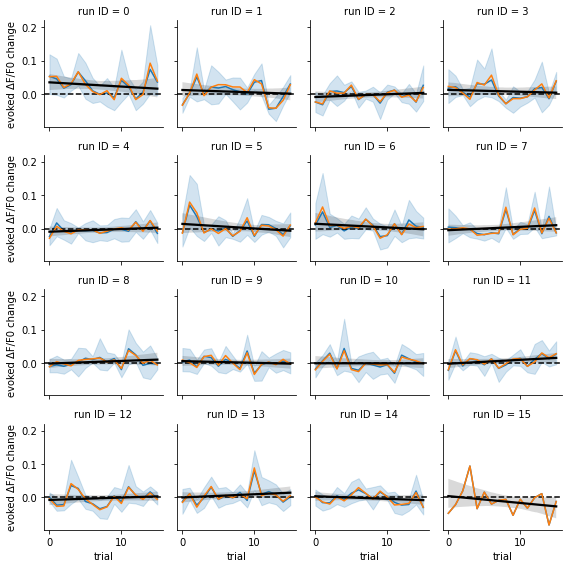

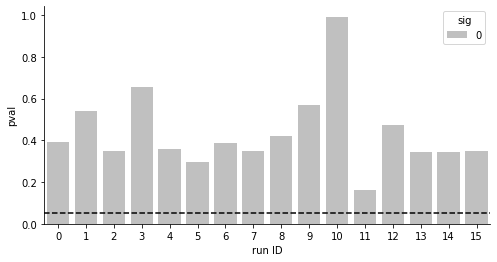

In [44]:
from constants import PTHR_STATIONARITY

# Plot response strength over trial sequence, by run ID, with superimposed linear regression estimate
logger.info(f'plotting {ykey_diff} along trial sequences...')
fg = sns.relplot(
    kind='line',
    data=popagg_stats,
    **trialseq_fgkwargs
)
fg.refline(y=0, c='k')
for ax, (_, gdata) in zip(fg.axes, weighted_popagg_stats.groupby(stationarity_gby)):
    ax.plot(gdata.index.get_level_values(Label.TRIAL), gdata['mean'], c='C1')
logger.info('adding regression estimates...')
fg.map_dataframe(
    sns.regplot, 
    scatter=False, 
    color='k', 
    x=Label.TRIAL, 
    y=ykey_diff
)
figs[f'{ykey_diff} stationarity along trial seq'] = fg.figure

# Perform detailed linear regression on lumped data, by run ID, to assess response stationarity
logger.info(f'assessing {ykey_diff} stationarity, by run ID, with linear regression analysis')
cross_dataset_linreg_stats = (popagg_stats
    .groupby(stationarity_gby)
    [ykey_diff]
    .apply(apply_linregress)
    .unstack()
    .assign(sig=lambda df: assess_significance(df, PTHR_STATIONARITY, sign_key='slope'))
)

# Plot stationarity p-value for each run ID
figs[f'{ykey_diff} stationarity p-value by run'], ax = plt.subplots(figsize=(8, 4))
sns.despine(ax=ax)
sns.barplot(
    data=cross_dataset_linreg_stats.reset_index(),
    x=stationarity_gby,
    y='pval',
    hue='sig',
    palette=Palette.TERNARY,
    dodge=False,
)
ax.axhline(PTHR_STATIONARITY, ls='--', c='k')

# Identify and mark runs with non-stationarity in response strength
non_stationary_runs = cross_dataset_linreg_stats[cross_dataset_linreg_stats['sig'] != 0].index.values
has_non_stationary_runs = len(non_stationary_runs) > 0
if has_non_stationary_runs > 0:
    logger.info(f'identified {ykey_diff} non-stationarity in runs {non_stationary_runs}')
    for k in non_stationary_runs:
        fg.axes_dict[k].set_title(f'{fg.axes_dict[k].get_title()} *', fontsize=10)
else:
    logger.info(f'no significant {ykey_diff} non-stationarity identified')

### Correct non-stationary runs by excluding initial trials

In [45]:
%%skip (not $has_non_stationary_runs)

# Create figure backbone
figs[f'{ykey_diff} stationarity p-value vs starting index'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_xlabel('starting trial index')
ax.set_ylabel('stationarity p-value')
ax.axhline(PTHR_STATIONARITY, c='k', ls='--')

# Define list of starting indexes
istarts = np.sort(popagg_stats.index.unique(Label.TRIAL))[:-1]
istart_stationary = {}

# For each category with non-stationary response
for i, k in enumerate(non_stationary_runs):
    tmpdata = popagg_stats.query(f'`{stationarity_gby}` == {k}')
    pvals = []
    # Gradually remove trials, and re-analyze response stationarity
    for istart in istarts:
        res = apply_linregress(tmpdata.loc[pd.IndexSlice[:, :, istart:], ykey_diff])
        pvals.append(res['pval'])
    pvals = np.array(pvals)
    ax.plot(istarts, pvals, label=k, c=f'C{i}')

    # Identify first starting index for which response is stationary
    istart_stationary[k] = np.where(pvals > PTHR_STATIONARITY)[0][0]
    ax.axvline(istart_stationary[k], ls='--', c=f'C{i}')

ax.legend(title=stationarity_gby)

# Exclude problematic trials from stats
for k, istart in istart_stationary.items():
    logger.info(f'excluding trials < {istart} for {stationarity_gby} {k} from stats...')
    # Use conditional slicing to remove problematic trials of particular run ID
    try:
        group_cond = ext_stats[stationarity_gby] == k
    except KeyError:
        group_cond = ext_stats.index.get_level_values(stationarity_gby) == k
    trialcond = ext_stats.index.get_level_values(Label.TRIAL) < istart
    ext_stats = ext_stats[~np.logical_and(group_cond, trialcond)]

# Compute number of valid trials per dataset, ROI and run
logger.info('computing number of valid trials per dataset, ROI and run...')
nvalidtrials_per_run = (ext_stats
    .groupby([Label.DATASET, Label.ROI, Label.RUN])
    .count()
    .max(axis=1)
)
zfactors = np.sqrt(nvalidtrials_per_run)

# Aggregate over trials
logger.info('re-computing trial-aggregated stats')
trialagg_stats = get_trial_aggregated(ext_stats, aggfunc=trial_aggfunc)

# Rescale z-scores
logger.info('rescaling z-scores post-averaging...')
trialagg_stats[get_change_key(Label.ZSCORE)] *= zfactors

# Classify responses
logger.info('re-classifying responses based on corrected aggregate data...')
ykey_diff = get_change_key(ykey_classification)
zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
    trialagg_stats[ykey_diff], zthr, directional=directional)

# Classify responders
roistats = classify_ROIs(trialagg_stats)
for k in roistats:
    trialagg_stats[k] = roistats[k]

### Plot evoked change distribution for control condition (P = 0)

 06/03/2023 17:14:44: response type proportions at P = 0:
weak        94.514768
positive     5.485232
Name: response type, dtype: float64


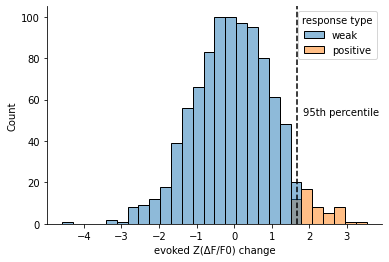

In [46]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Plot parameter dependency curves

In [47]:
%%skip (not $has_non_stationary_runs)
figs['stimparamdeps_global_postcorrection'] = plot_all_deps(
    trialagg_stats, 
    [Label.P, Label.DC, Label.ISPTA], 
    ykeys_plt,
    palette='uniform',
    avg_color='line',
)

### ROI breakdown per dataset

 06/03/2023 17:14:51: computing fraction of response occurence per ROI over 10 "strong ISPTA" conditions...
 06/03/2023 17:14:51: identified 3.4% of responders with 0.5 as threshold proportion of responding conditions
 06/03/2023 17:14:51: plotting cell maps...


100%|██████████| 9/9 [00:01<00:00,  6.96it/s]


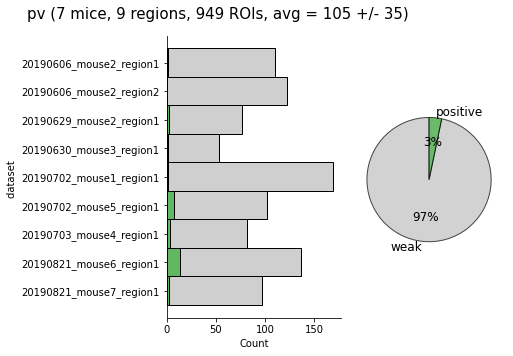

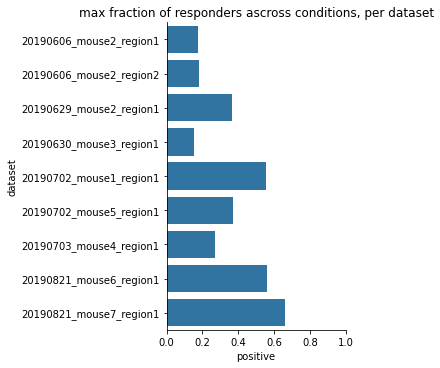

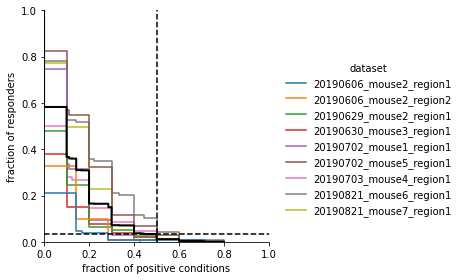

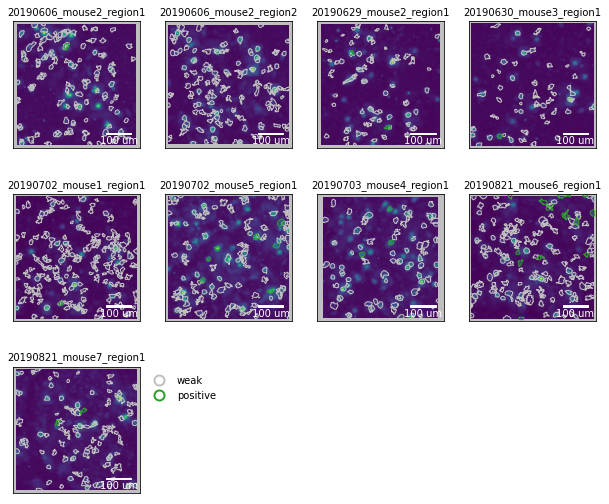

In [48]:
# Plot cell count breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_cell_maps(ROI_masks, trialagg_stats, map_ops, refkey='Vcorr', mode='contour')

### Examine variability of responses

In [49]:
%%skip True
# Get fraction of responders for each dataset, run & trial
ext_resp_props = get_responders_counts(
    ext_stats, Label.RUN, units=[Label.DATASET, Label.TRIAL], normalize=True)

# Plot distirbution of responder fraction across datasets & trial, per condition
sns.catplot(
    data=ext_resp_props.reset_index(Label.RUN),
    kind='box',
    y='positive',
    x=Label.RUN,
    height=4,
    aspect=2
)

# Compute population-average stats for each trial 
popagg_stats = (
    ext_stats[[ykey_diff, Label.ISPTA, Label.RUNID]]
    .groupby([Label.DATASET, Label.RUN, Label.TRIAL])
    .mean()
)
popagg_stats[Label.RUNID] = popagg_stats[Label.RUNID].astype(int)

# testdata = ext_resp_props['positive']
testdata = ext_stats[ykey_diff]
testgroupby = [Label.RUN, Label.DATASET]
pthr = PTHR_DETECTION

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle(f'tests on {testdata.name} distributions')
sns.despine(fig=fig)
histkwargs = dict(
    x='pval',
    bins=np.linspace(0, 1, 21),
    stat='density',
    hue='H0'
)
# Test if distributions are normal
from scipy.stats import normaltest
isnormal = apply_test(
    testdata, testgroupby, normaltest, pthr=pthr)
axes[0].set_title('normal test (H0: normal)')
sns.histplot(
    ax=axes[0],
    data=isnormal,
    **histkwargs
)

# Test if distributions are multimodal
from diptest import diptest
ismultimodal = apply_test(
    testdata, testgroupby, diptest, pthr=pthr)
axes[1].set_title('dip test (H0: unimodal)')
sns.histplot(
    ax=axes[1],
    data=ismultimodal,
    **histkwargs
)

In [50]:
%%skip True
# For each dataset, compute 2-way ANOVA for trial vs. ROI
Ftable = ext_stats[ykey_diff].groupby(Label.DATASET).agg(compute_ROI_vs_trial_anova)
Ftable = pd.DataFrame(
    Ftable.tolist(),
    columns=[f'F({Label.TRIAL})', f'F({Label.ROI})'],
    index=Ftable.index
)
# Plot resulting F-scores on 2D scatter graph
fig, ax = plt.subplots()
sns.despine(ax=ax)
sns.scatterplot(
    data=Ftable,
    x=f'F({Label.TRIAL})',
    y=f'F({Label.ROI})',
    ax=ax
)
xymax = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(0, xymax)
ax.set_ylim(0, xymax)
ax.axline((0, 0), (1, 1), ls='--', color='k')
ax.set_aspect(1.)

### Plot trial heatmap per condition for entire mouse line

In [51]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_trial_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

### Plot response traces

In [52]:
%%skip $skip_traces

# Get plot-ready traces dataset
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Align DFF and z-score traces w.r.t their pre-stimulus average
plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
    plt_data[[Label.DFF, Label.ZSCORE]], FrameIndex.PRESTIM)

# Get onset slice
mux_slice = slice_last_dim(plt_data.index, FrameIndex.STIM)

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None # Label.ROI_RESP_TYPE

# For each output variable
for ykey in ykeys_plt:

    # Pressure-dependent and dutcy cycle dependent response traces, per dataset
    for pkey in pkeys:
        figs.update(
            plot_responses_across_datasets(
                plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []  
    for pkey in pkeys:
        figs[f'{ykey} vs. {pkey} by type'] = plot_responses_across_datasets(
            plt_data, ykey=ykey, pkey=pkey, avg=True, groupby=groupby)
        avgaxes = avgaxes + figs[f'{ykey} vs. {pkey} by type'].axes
    harmonize_axes_limits(avgaxes)

### Save responder-type-averaged stats to disk

In [53]:
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)
fpath = os.path.join(lineagg_dir, f'{mouseline}.csv')
lineagg_stats = get_crossdataset_average(
    trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, add_global_avg=True)
logger.info(f'saving line-aggregated stats to {fpath}...')
lineagg_stats.to_csv(fpath)

 06/03/2023 17:15:03: computing ROI-weighted average of (9 datasets x 347 ROIs x 15 runs) dataframe across run...
 06/03/2023 17:15:03: computing ROI-weighted average of (9 datasets x 347 ROIs x 15 runs) dataframe across run...
 06/03/2023 17:15:03: saving line-aggregated stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/main/pv.csv...


### Save figures

In [54]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 06/03/2023 17:15:05: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.03.06/figs_main_pv_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 19/19 [00:04<00:00,  4.06it/s]


### Notify upon completion

In [55]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 06/03/2023 17:15:10: pv batch notebook completed in 0:01:28.065924 s
